In [13]:
import pandas as pd
import numpy as np

def get_df():
    """Imports and cleans music data in dataframe"""
    df = pd.read_csv('My_Music.csv')
    df.columns = df.columns.str.lower()
    
    #dtypes
    df['date added'] = pd.to_datetime(df['date added'])
    df['last played'] = pd.to_datetime(df['last played'])
    
    #Loved
    df.drop(df[df['loved'] == '5/31/2016 7:03 PM'].index, inplace=True)
    df.drop(df[df['loved'].isnull() == True].index, inplace=True)
    df.loc[:,'loved'] = df['loved'].astype(int) > 0
    
    #rating to stars
    df.loc[:,'rating'].fillna(0, inplace=True)
    df.loc[:,'rating'] = df['rating']/20
    df.loc[:,'rating'] = df['rating'].astype(float)
    df.rename(columns={'rating':'stars', 'name':'song'}, inplace=True)
    df.loc[(df[(df['stars'] > 2) & (df['loved'] == False)].index), 'stars'] = 0
    
    return df

get_df().sort_values('date added', ascending=False).head()

,album artist,song,time,artist,album,genre,loved,plays,date added,stars,year,last played
3178,NaN,Caledonia Soul Music,17:15,Van Morrison,NaN,Jam Session,True,4.0,2020-09-11 13:03:00,0.0,NaN,2020-09-12 11:11:00
3179,Jim Croce,Operator (That's Not the Way It Feels),3:50,Jim Croce,You Don't Mess Around With Jim,Rock,False,2.0,2020-09-10 23:26:00,0.0,1972.0,2020-09-12 11:15:00
3180,Jim Croce,"Bad, Bad Leroy Brown",3:02,Jim Croce,Life & Times,Rock,True,3.0,2020-09-10 23:18:00,0.0,1973.0,2020-09-12 11:23:00
3181,Bon Iver,U (Man Like),2:26,Bon Iver,"i,i",Alternative,False,2.0,2020-09-10 22:04:00,0.0,2019.0,2020-09-12 11:25:00
3182,Bon Iver,Jelmore,2:30,Bon Iver,"i,i",Alternative,False,2.0,2020-09-10 22:04:00,0.0,2019.0,2020-09-12 11:27:00


In [31]:
def get_artist_stats(listened_since = '1990', added_since = '1990', sort = 'comp. score', added_before = '2040'):
    """
    Returns a sorted pivot table containing information on artists whose songs have been 
    played since a given datetime. Aggregates total number of stars, total number of plays 
    of the songs, and number of songs.
    """
    
    df = get_df()
    df = df[df['last played'] > listened_since]
    df = df[df['date added'] < added_before]    
    df = df[df['date added'] > added_since]
    
    df.loc[(df[(df['stars'] == 0) & (df['loved'] == True)].index), 'stars'] = 2.5
    df.loc[(df[(df['stars'] == 2)].index), 'stars'] = 0

    
    df['adj. rating'] = df['stars']**2 / 2.5
    df['comp. score'] = df['stars']**2 / 2.5 + np.sqrt(df['plays'])

    df = df[['artist', 'song', 'stars', 'plays', 'loved', 'adj. rating', 'comp. score', 'year']].groupby('artist').agg({'song':'count', 
                                                                                  'stars':sum, 'loved':sum, 'plays':sum, 
                                                                                  'adj. rating':sum, 'comp. score':sum, 
                                                                                  'year':'mean' }).round(0).fillna(0).astype(int)
    df.rename(columns = {'song': 'songs'}, inplace=True)
    
    df['comp.**2 / loved'] = (df['comp. score']**2 / df['loved']).round(1)
    df['comp.**2 / loved'].replace(np.inf, 0, inplace=True)
    
    return df.sort_values('adj. rating', ascending=False)

get_artist_stats(listened_since = '2019').head(15)

,songs,stars,loved,plays,adj. rating,comp. score,year,comp.**2 / loved
artist,,,,,,,,
John Mayer,100,204,58,3196,312,840,2009,12165.5
Jack Johnson,102,144,45,1975,200,608,2007,8214.8
Ben Howard,44,78,18,701,139,300,2013,5000.0
Zac Brown Band,40,84,24,1153,126,309,2014,3978.4
Lord Huron,39,80,22,1014,125,315,2015,4510.2
Jason Mraz,36,78,21,876,122,273,2010,3549.0
The Tallest Man On Earth,33,70,20,597,106,234,2014,2737.8
Ed Sheeran,45,68,20,736,99,260,2015,3380.0
Switchfoot,26,58,15,482,95,189,2009,2381.4


In [225]:
def get_genre_stats(listened_since = '1990', added_since = '1990', sort = 'stars'):
    """
    Returns a sorted pivot table containing information on artists whose songs have been 
    played since a given datetime. Aggregates total number of stars, total number of plays 
    of the songs, and number of songs.
    """
    
    
    df = get_df()
    df = df[df['last played'] > listened_since]
    df = df[df['date added'] > added_since]
    df = df[['genre', 'song', 'stars', 'plays', 'loved']].groupby('genre').agg({'song':'count', 
                                                                                  'stars':sum, 
                                                                                  'loved':sum,
                                                                                  'plays':sum, })
    df.rename(columns = {'song': 'songs'}, inplace=True)
    
    return df.sort_values(sort, ascending=False)



In [226]:
def top_artists(songtolovedfactor = 1.8, listened_since = '2019', added_before = '2040', added_since = '1990'):
    """
    Returns a list of top artists by excluding artists that fall beneath thresholds of songs, 
    loved songs, and songs per loved song (to exclude artists making the list whose previously 
    loved hits were the only ones listened to)
    """
    df = get_artist_stats(listened_since = listened_since, added_before=added_before, sort='comp. score')
    df = df[(df['loved'] > 5) & (df['songs'] > 9) & (df['songs'] > df['loved'] * songtolovedfactor)]
    return df

top_artists()

,songs,stars,loved,plays,comp. score,year,comp.**2 / loved
artist,,,,,,,
John Mayer,100,189.0,55.0,3193.0,285.8,2009.2,1485.120727
Jack Johnson,102,144.0,45.0,1975.0,200.0,2007.4,888.888889
Ben Howard,44,78.0,18.0,701.0,139.2,2013.4,1076.480000
Ed Sheeran,45,65.5,19.0,736.0,96.1,2015.3,486.063684
The California Honeydrops,44,59.5,17.0,662.0,90.3,2016.6,479.652353
Hozier,35,43.5,12.0,337.0,66.7,2016.4,370.740833
Trevor Hall,22,40.5,11.0,442.0,63.9,2013.7,371.200909
Coldplay,31,40.0,11.0,735.0,62.8,2013.6,358.530909
Leon Bridges,27,33.0,9.0,544.0,50.8,2016.4,286.737778


In [227]:
df = get_df()
df.head()

,album artist,song,time,artist,album,genre,loved,plays,date added,stars,year,last played
0,1 World,African Herbsman (ADroiD & Lotus Remix),3:46,1 World,African Herbsman (ADroiD & Lotus Remix) - Single,Dance,False,2.0,2017-04-17 15:26:00,0.0,1973.0,2018-02-25 08:17:00
1,The 1975,Love It If We Made It,4:13,The 1975,A Brief Inquiry Into Online Relationships,Alternative,False,4.0,2020-09-09 14:02:00,0.0,2018.0,2020-09-09 16:33:00
2,The 1975,Sincerity Is Scary,3:46,The 1975,A Brief Inquiry Into Online Relationships,Alternative,False,5.0,2020-09-09 14:06:00,0.0,2018.0,2020-09-09 16:36:00
3,The 1975,It's Not Living (If It's Not With You),4:08,The 1975,A Brief Inquiry Into Online Relationships,Alternative,False,6.0,2020-04-08 11:08:00,0.0,2018.0,2020-09-09 16:40:00
4,The 1975,Mine,4:07,The 1975,A Brief Inquiry Into Online Relationships,Alternative,False,4.0,2020-09-09 14:13:00,0.0,2018.0,2020-09-09 16:45:00


In [228]:
get_genre_stats(listened_since = '2020', sort='stars').head(10)

,songs,stars,loved,plays
genre,,,,
Pop,245,413.0,142.0,4758.0
Rock,254,351.0,138.0,5887.0
Alternative,282,343.0,125.0,4308.0
Dance,122,232.0,76.0,2463.0
R&B/Soul,122,143.0,55.0,1646.0
Singer/Songwriter,101,125.0,47.0,1662.0
Country,59,111.0,36.0,1528.0
Hip-Hop/Rap,71,105.0,41.0,594.0
Electronic,59,59.0,29.0,976.0


In [280]:
top = top_artists(added_before = '2016', listened_since='2018')
top

,songs,stars,loved,plays,comp. score,year,comp.**2 / loved
artist,,,,,,,
Ed Sheeran,22,39.0,11.0,350.0,58.6,2012.6,312.178182
Drake,33,47.0,16.0,345.0,56.0,2011.5,196.000000
Taylor Swift,31,41.0,13.0,199.0,53.6,2012.4,220.996923
Parachute,17,27.0,8.0,462.0,38.0,2011.5,180.500000
Eminem,14,22.5,7.0,96.0,29.7,2008.9,126.012857
Childish Gambino,11,17.0,6.0,79.0,19.4,2013.1,62.726667


<IPython.core.display.Javascript object>


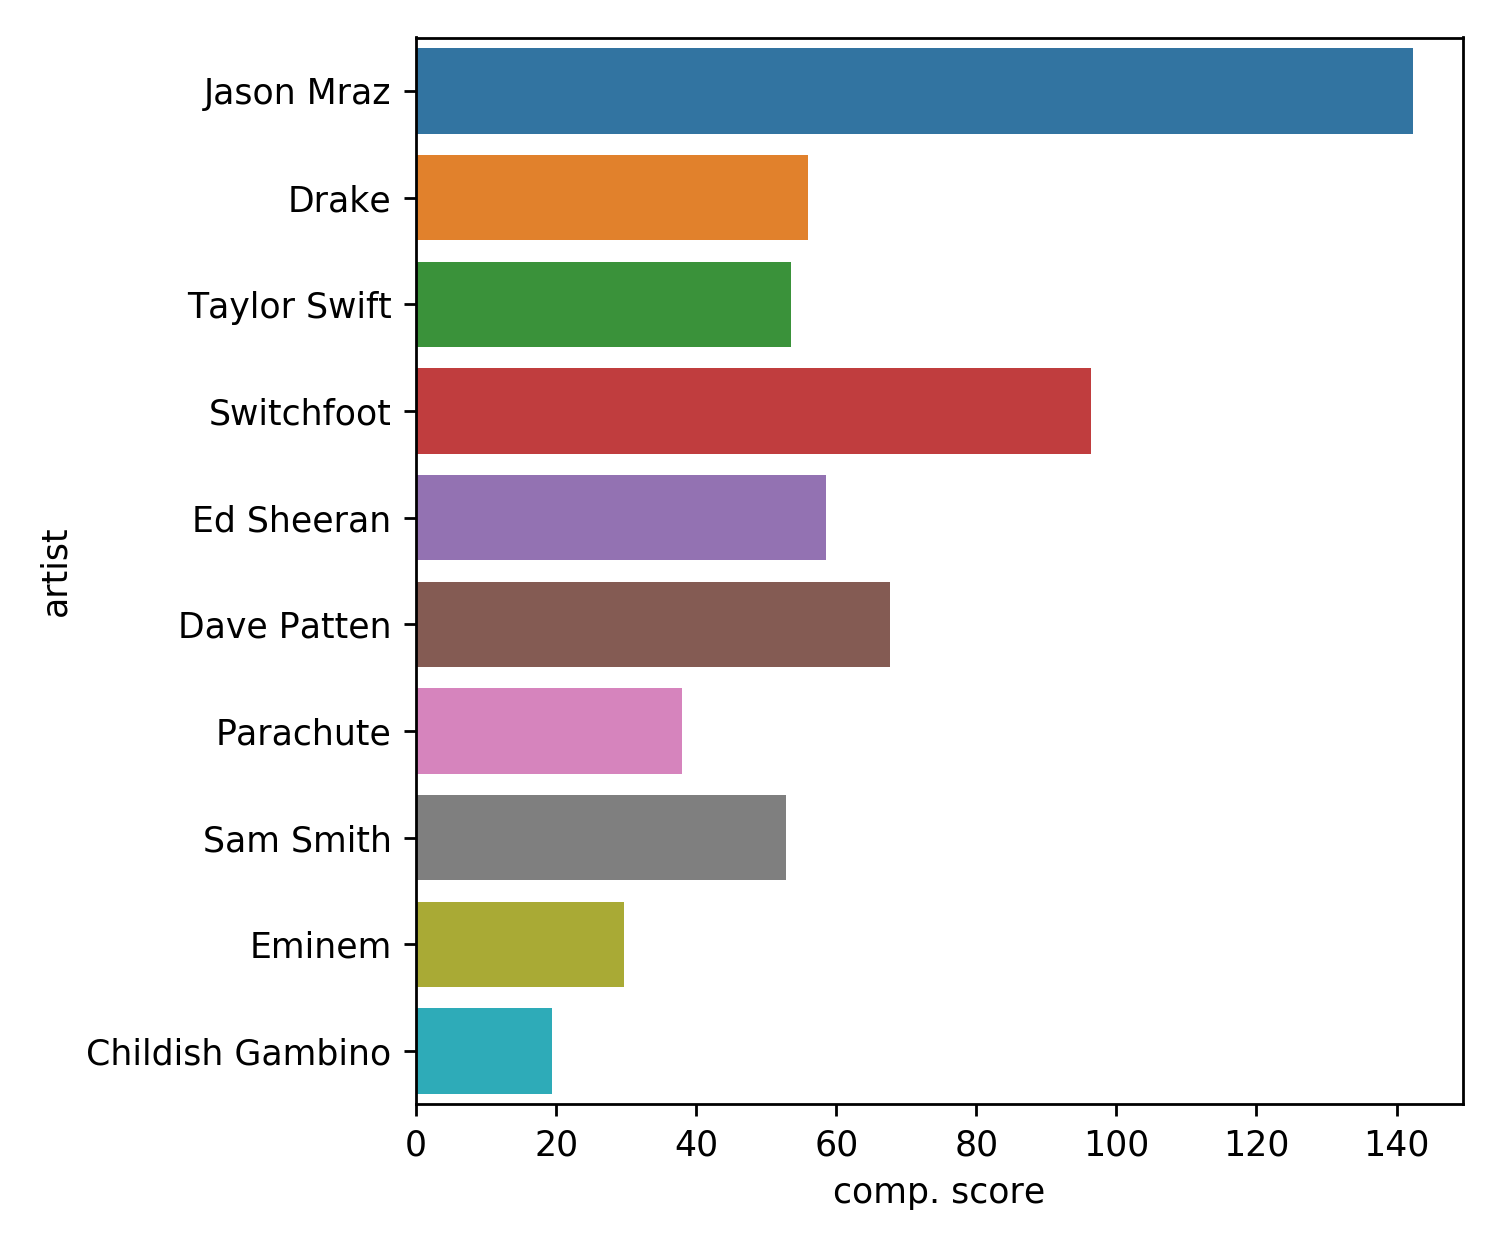

In [284]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib notebook

top = top_artists(added_before = '2016', listened_since = '2018', songtolovedfactor=1.5).head(15)

fig = plt.figure(figsize=(6,5))
sns.barplot(top.sort_values('songs', ascending=False)['comp. score'], top.sort_values('songs', ascending=False).index)
fig.tight_layout()

<IPython.core.display.Javascript object>


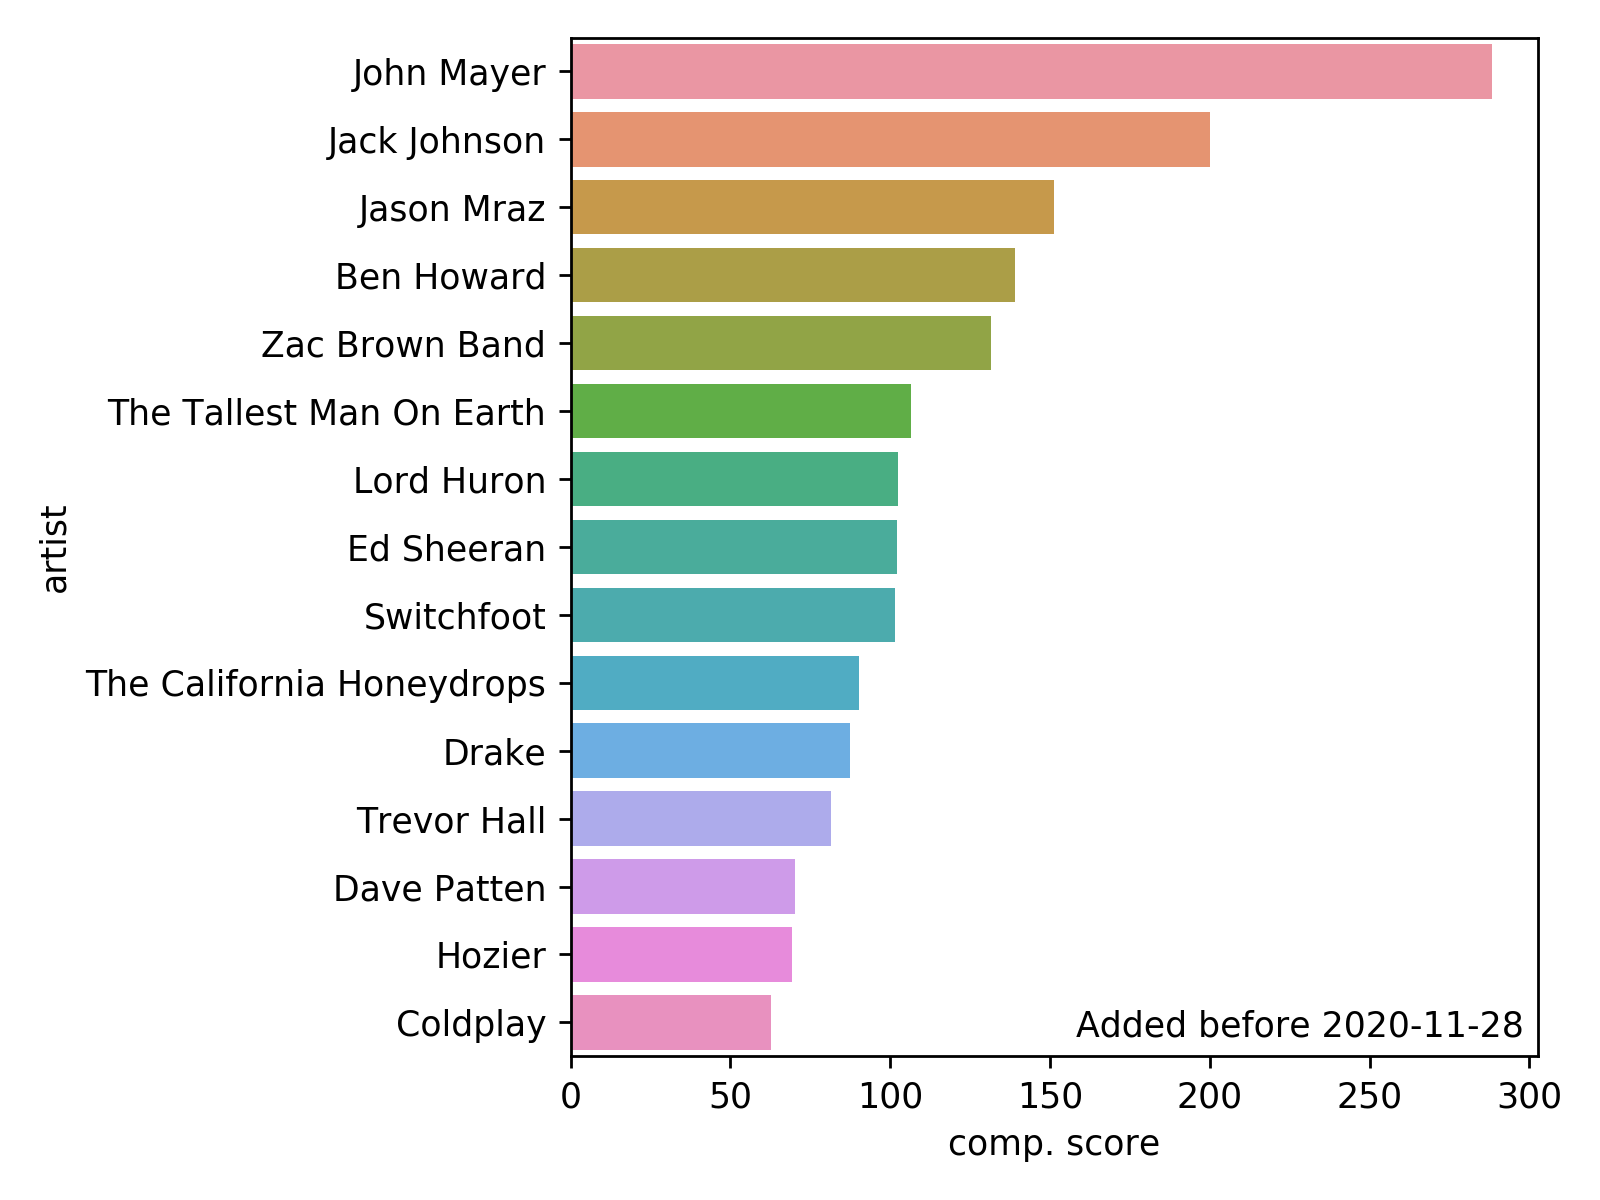

In [321]:
n=88
def update(curr):
    if curr == n:
        a.event_source.stop()
    plt.cla()
    x = datetime.datetime(2013,8,1) + curr * timedelta(days=365/12)
    top = top_artists(added_before = x, listened_since = '2018', songtolovedfactor=1.5).head(15)
    sns.barplot(top['comp. score'], top.index)
    fig.tight_layout()
    plt.annotate('Added before {}'.format(x.date()), (310,47), xycoords='figure points')
    
fig = plt.figure()
a = animation.FuncAnimation(fig, update, interval=500)

#a.save('compbydateadded.mp4')